The autograder will run with the following imports (and only the following imports). PIL is required to complete this assignment, though scipy is also needed if you want to compare your luminence-based solution to the optimal KD-tree solution.

In [1]:
from PIL import Image
import PIL

import numpy as np
import math, time
from utils import bstNode

import sys
from scipy.spatial import KDTree

The following code is provided to assist you with importing and converting images to multi-dimensional arrays. Parts of this code may look familiar to you! **You will not need to edit any part of these code blocks and doing so may crash the autograder. TOUCH AT YOUR OWN RISK!**

In [2]:
# The previous printTree functions in earlier assignments don't scale well
# and have a hard time printing nodes containing size-3 tuples as keys. 
# To address both of these issues, here is a simple vertical printer
# for the shape of your trees.
def printTree(node, depth=0):
    if node != None:
        printTree(node.right, depth + 1)
        print(' ' * 4 * depth + '|--' + str(node.key))
        printTree(node.left, depth + 1)

# This is the same print but printing a 1D luminance value 
# Your tree *should* store RGB tuples but is organized by luminance
# So this may be useful for conceptual debugging
def printTree_asLum(node, depth=0):
    if node != None:
        col = getLum(node.key)
        printTree_asLum(node.right, depth + 1)
        print(' ' * 4 * depth + '|--' + "{:.2f}".format(col))
        printTree_asLum(node.left, depth + 1)

# The following parts of this file were modified from Wade Fagen-Ulmschneider and Karle Flanagan's 
# STAT 107 Data Science Mosaic Project DISCOVERY.py file. 
# Details can be found at https://discovery.cs.illinois.edu/

#INPUT:
# A string containing the path to a PNG image (fileName)
# An integer containing the square dimension the image should be reduced to (resize)
#OUTPUT:
# A numpy array containing a (row, column, color vector) 3D array
def loadImage(fileName, resize = None):
  # Open the image using the PIL library
  image = Image.open(fileName)
  
  # Converts image to RGB format
  image = image.convert('RGB')

  # If resize is given a number, resize to that size square.
  if resize:
    image = squareAndResizeImage(image, resize)

  # Store image in a (row, column, color vector) 3D array
  rgb = np.array(image, dtype=np.uint8)
  return rgb 


#INPUT:
# A Pillow Image containing the image being resized
# An integer containing the square dimension the image should be reduced to (resize)
#OUTPUT:
# A Pillow Image containing the cropped, resized, and resampled image.
def squareAndResizeImage(image, resize):
  w, h = image.size
  d = min(w, h)
  image = image.crop( (0, 0, d, d) ).resize( (resize, resize), resample=PIL.Image.LANCZOS )
  #image.show()
  return image

#INPUT:
# A string containing the path to an image file
#OUTPUT:
# A bool if the file exists and is of the correct type
def isImageFile(file):
  for ext in [".png"]: # Code can only handle png currently
    if file.endswith(ext) or file.endswith(ext.upper()):
      return True
  return False

#INPUT:
# A string containing the path to a file location
#OUTPUT:
# A list of strings containing the paths to all valid image files at that location
def listTileImagesInPath(path):
  from os import listdir
  from os.path import isfile, join

  files = []
  for f in listdir(path + "/"):
    file = join(path + "/", f)
    if isfile(file) and isImageFile(file):
      files.append(file)

  return files

imageCache = {}


#INPUT:
# A string containing the path to a file location
# An optional integer argument that will resize the input image into a square of the appropriate size 
#OUTPUT:
# A numpy array storing a 3D (row, col, color) representation of an image
def getTileImage(fileName, size=None):
  key = f"{fileName}-{size}px"

  if key not in imageCache:
    imageCache[key] = loadImage(fileName, size)

  return imageCache[key]

Code you should modify (and complete) can be found below: 

In [3]:
#grade

#INPUT:
# Two size-3 tuples containing RGB values being compared
#OUTPUT:
# A float containing the Euclidian distance between these colors
# HINT: math.sqrt() exists and can be used here.
# Dont delete the import math line if you do!
def exactColorDist(c1, c2):
    import math
    # YOUR CODE HERE
    distance = math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2)
    return distance

In [4]:
#grade

#INPUT:
# A list of size-3 tuples containing average colors (inlist)
# A size-3 tuple containing the query color of interest (query)
#OUTPUT:
# A size-3 tuple which is the closest match to the input query
# among every item in inlist
# HINT: You will need exactColorDist to solve this.
def getClosestColor(inlist, query):
    # YOUR CODE HERE
    closest_color = None
    closest_distance = float('inf')
    for color in inlist:
        distance = exactColorDist(color, query)
        if distance < closest_distance:
            closest_color = color
            closest_distance = distance
    return closest_color

In [5]:
#grade

#INPUT:
# A 3D numpy array indexed by [row][col][RGB-color]) (numArray)
# Four optional integer arguments:
# rstart gives the starting index (in rows) that must be averaged
# cstart gives the starting index (in cols) that must be averaged
# rlen & clen give the length of values that must be averaged (starting from start indices)
# With all four optional arguments, this forms a rectangle.
# Remember that 0,0 is the top left of an image
#OUTPUT:
# A size-3 tuple containing the average color of the image (or subimage defined by four args)
def getAverageColor(numArray, rstart=0, cstart=0, rlen=None, clen=None):
    #YOUR CODE HERE
    if rlen is None:
        rlen = numArray.shape[0] - rstart
    if clen is None:
        clen = numArray.shape[1] - cstart
    subarray = numArray[rstart:rstart + rlen, cstart:cstart + clen, :]
    avg_color = tuple(np.mean(subarray, axis=(0, 1)).astype(int))
    return avg_color



In [6]:
#grade

# INPUT:
# A size-3 tuple containing (RGB) values in order.
# OUTPUT:
# The relative luminance of the color as a float
# NOTE: There are many luminance calculations. 
# We are using a value that favors 'human vision' over 
# mathematical precision: 
# L = 0.299 R + 0.587 G + 0.114 B
# DO NOT EDIT OR REMOVE THIS FUNCTION (will break autograder)
def getLum(color):
    return 0.299*color[0]+0.587*color[1]+0.114*color[2]

# INPUT: 
# A list of size-3 tuples containing the average color values of different images (avgColorList)
# A dictionary containing a mapping of average colors as keys to image file paths as values (imageDict)
# OUTPUT:
# A bstNode containing the root of a luminance tree
# NOTE: The luminance tree stores average colors as keys and image file paths as values
# DO NOT EDIT OR REMOVE THIS FUNCTION (will break autograder)
def build_lum_tree(avgColorList, imageDict):
    root = None

    for k in avgColorList:
        root = lum_tree_insert(root, k, imageDict[k])

    return root


# INPUT: 
# A bstNode containing the root of the tree (or sub-tree) being inserted into. (root)
# A size-3 tuple containing the average color of the image being inserted (key)
# A string containing the path and filename to the image being inserted (val)
# OUTPUT:
# A bstNode containing the root of the tree after the new node has been added
# HINT: Use 'getLum' to compare values as 1D luminance NOT as 3D colors.
def lum_tree_insert(root, key, value):
    # YOUR CODE HERE
    if root is None:
        return bstNode(key, value)
    elif getLum(key) < getLum(root.key):
        root.left = lum_tree_insert(root.left, key, value)
    else:
        root.right = lum_tree_insert(root.right, key, value)
    return root

# INPUT: 
# A bstNode containing the root of the tree (or sub-tree) being inserted into. (root)
# A size-3 tuple containing the average color being queried (key)
# OUTPUT:
# A bstNode containing the closest match (in luminance) between query and any node in the tree
# HINT: Use 'getLum' to compare values as 1D luminance NOT as 3D colors.
def lum_tree_find(root, key):
    # YOUR CODE HERE
    bestNode = None
    bestDist = float('inf')
    while root is not None:
        distance = abs(getLum(key) - getLum(root.key))
        if distance < bestDist:
            bestDist = distance
            bestNode = root
        if getLum(key) < getLum(root.key):
            root = root.left
        else:
            root = root.right
    return bestNode

Run-Code: Use this code block to manually check the correctness of your methods.

In [8]:
# Start by making sure your getAverageColor works! 
# Use some of the monochrome colors to make sure you are reading flat colors correctly
print(getAverageColor(getTileImage("data/rainbow/color_0.png"))) # Should print (255, 0, 0)
print(getAverageColor(getTileImage("data/rainbow/color_1.png"))) # Should print (255, 255, 0)
print(getAverageColor(getTileImage("data/monochrome/random_0.png"))) # Should print (149, 247, 5)
print(getAverageColor(getTileImage("data/monochrome/random_1.png"))) # Should print (121, 246, 111)

# Then try some of the more complex images to make sure you can average colors correctly
print(getAverageColor(getTileImage('data/igram/12555993_758082880957962_1728145408_n.png'))) # Should print (119, 102, 87)
print(getAverageColor(getTileImage('data/igram/21041515_1557176067694481_2766301243222523904_n.png'))) # Should print (108, 87, 77)
print(getAverageColor(getTileImage('data/igram/11111253_795941653819394_229580809_n.png'))) # Should print (148, 150, 149)
print(getAverageColor(getTileImage('data/igram/10009374_1035844769820800_1616234408_n.png'))) # Should print (121, 136, 139)

# Make sure your Euclidean Distance calculation works
print(exactColorDist((255, 0, 0), (255, 255, 0))) # 255.0
print(exactColorDist((255, 0, 0), (255, 255, 255))) # 360.62445840513925
print(exactColorDist((121, 246, 111), (149, 247, 5))) # 109.64032105024137
print(exactColorDist((149, 247, 5), (121, 246, 111))) # 109.64032105024137
print(exactColorDist((255, 255, 0), (200, 200, 0))) # 77.78174593052023

# This generates a list of fileNames
# Test datasets include 'rainbow', 'monochrome', and 'igram'
imlist = listTileImagesInPath("data/rainbow")

# A dictionary mapping average colors to filenames is needed to build the luminance tree
# Here is an example of how to build such a dictioanry
colord = {}
for i in imlist:
    avg = getAverageColor(getTileImage(i))
    colord[avg]=i

# To run naive search, create a list of average colors
# And pass that as input to 'getClosestColor'
# These values were built using data/rainbow
l = list(colord.keys())
print(getClosestColor(l, (200, 200, 0))) # Closest color is (255, 255, 0)
print(getClosestColor(l, (200, 5, 10))) # Closest color is (255, 0, 0)
print(getClosestColor(l,(90, 75, 50))) # Closest color is (255, 0, 0)

# To run luminance binary search, create a luminance binary tree
t = build_lum_tree(l, colord) # This tests your lum_tree_insert

printTree(t)
''' Using data/rainbow final tree is: 
        |--(255, 255, 0)
    |--(0, 255, 255)
|--(0, 255, 0)
        |--(255, 0, 255)
    |--(255, 0, 0)
        |--(0, 0, 255)
'''
''' Using data/monochrome final tree is:
                |--(255, 234, 39)
            |--(208, 246, 88)
                |--(227, 190, 245)
        |--(154, 233, 166)
    |--(133, 255, 99)
                |--(121, 246, 111)
            |--(222, 181, 160)
                |--(149, 247, 5)
        |--(180, 226, 14)
'''

node = lum_tree_find(t,(200, 200, 0)) # (0, 255, 255) data/rainbow/color_3.png
print(node.key, node.val)
node = lum_tree_find(t,(200, 5, 10)) # (255, 0, 0) data/rainbow/color_0.png
print(node.key, node.val)
node = lum_tree_find(t,(90, 75, 50)) # (255, 0, 0) data/rainbow/color_0.png
print(node.key, node.val)

# The KDTree only needs an input list to build
# These values were built using data/rainbow
kdt = KDTree(l)
best = kdt.query((200, 200, 0))
# The KDTree output is the magnitude of the closest distance and the index of the matching value
print(best[0], best[1]) # 77.78174593052023 2
# To get the actual color, we need to look it up in the original list:
print(l[best[1]]) # (255, 255, 0)

(255, 0, 0)
(255, 255, 0)
(149, 247, 5)
(121, 246, 111)
(119, 102, 87)
(108, 87, 77)
(148, 150, 149)
(121, 136, 139)
255.0
360.62445840513925
109.64032105024137
109.64032105024137
77.78174593052023
(255, 255, 0)
(255, 0, 0)
(255, 0, 0)
    |--(255, 255, 0)
|--(0, 255, 255)
        |--(0, 255, 0)
    |--(255, 0, 255)
        |--(255, 0, 0)
            |--(0, 0, 255)
(0, 255, 255) data/rainbow/color_3.png
(255, 0, 0) data/rainbow/color_0.png
(255, 0, 0) data/rainbow/color_0.png
77.78174593052023 1
(255, 255, 0)


Once you have implemented and tested your code, use the following commands to build your final image(s). Be sure to keep track of running times and don't set the values too high or you might be waiting around for a long time for your images to build (and the saved images might be very very large)

In [12]:
# What is your base image file name?
# baseImageFileName = "data/csdepartment.png"
baseImageFileName = "data/f1_ferrari.png"

# What folder contains your tile images?
# - You can change this so you can have multiple different folders of tile images.
tileImageFolder = "data/tiles/illinois-instagram-images/"

# What is the maximum number of tiles should your mosaic use across?
# - More tiles across will increase the quality of the final image.
# - More tiles across will cause your program to run slower.
# ...if you have bugs, start this value slow (it won't look great, but it will make it run fast!)
# ...a value around 200 usually looks quite good, but play around with this number!
maximumTilesX = 200

# What cols should your tiles be in your mosaic?
# - A larger tile image will result in a larger output file.
# - A larger tile image will result in your program running slower.
# - A larger tile image will result in more detail in the output file.
tileHeight = 32


In [10]:
# Create an array to record the runtime for each number of tiles
tiles_100 = []
tiles_200 = []
tiles_500 = []
tiles_800 = []
tiles_1200 = []

In [13]:
# The following parts of this file were modified from Wade Fagen-Ulmschneider and Karle Flanagan's 
# STAT 107 Data Science Mosaic Project DISCOVERY.py file. 
# Details can be found at https://discovery.cs.illinois.edu/

print(f"Loading your base image `{baseImageFileName}`...")
baseImage = loadImage(baseImageFileName)
height = len(baseImage)
width = len(baseImage[0])

print(f"Initializing data structures...")

# The Luminance-based binary tree
imlist = listTileImagesInPath(tileImageFolder)

colord = {}
for i in imlist:
    avg = getAverageColor(getTileImage(i))
    colord[avg]=i

l = list(colord.keys())
t = build_lum_tree(l, colord)

# The built-in KDTree
kdt = KDTree(l)

print(f"Finding best replacement image for each tile...")
# Find the pixelsPerTile to know the pixels used in the base image per mosaic tile:
pixelsPerTile = int(math.ceil(width / maximumTilesX))
width = int(math.floor(width / pixelsPerTile) * pixelsPerTile)
height = int(math.floor(height / pixelsPerTile) * pixelsPerTile)
tilesX = int(width / pixelsPerTile)
tilesY = int(height / pixelsPerTile)

# Create the mosaic:
for type in ['naive', 'lum', 'KD']:
  mosaic = Image.new('RGB', (int(tilesX * tileHeight), int(tilesY * tileHeight)))
  
  start = time.perf_counter()
  for x in range(0, width, pixelsPerTile):
    for y in range(0, height, pixelsPerTile):
      avg_color = getAverageColor(baseImage, y, x, pixelsPerTile, pixelsPerTile)

      # *** Naive Implementation using 'getClosestColor' every iteration ***
      if type=='naive':
        best = getClosestColor(l, avg_color)
        tile = getTileImage(colord[best], tileHeight)
        im = Image.fromarray(tile, "RGB")
        mosaic.paste(im, (int(x / pixelsPerTile) * tileHeight, int(y / pixelsPerTile) * tileHeight))
      # *** Efficient Implementation using luminance trees ***
      elif type == 'lum':
        best = lum_tree_find(t, avg_color)
        tile = getTileImage(best.val, tileHeight)
        im = Image.fromarray(tile, "RGB")
        mosaic.paste(im, (int(x / pixelsPerTile) * tileHeight, int(y / pixelsPerTile) * tileHeight))
      # *** Optimal solution using a built-in KD-tree ***
      elif type == 'KD':
        best = kdt.query(avg_color)[1]
        tile = getTileImage(colord[l[best]], tileHeight)
        im = Image.fromarray(tile, "RGB")
        mosaic.paste(im, (int(x / pixelsPerTile) * tileHeight, int(y / pixelsPerTile) * tileHeight))

    # Print out a progress message:
    curRow = int((x / pixelsPerTile) + 1)
    pct = (curRow / tilesX) * 100
    sys.stdout.write(f'\r  ...progress: {curRow * tilesY} / {tilesX * tilesY} ({pct:.2f}%)')

  
  end = time.perf_counter()
  totaltime = end-start

  # tiles_100.append(totaltime)
  # tiles_200.append(totaltime)
  # tiles_500.append(totaltime)
  # tiles_800.append(totaltime)
  tiles_1200.append(totaltime)

  # Save it
  mosaic.save('output/{}-mosaic-hq.png'.format(type))

  # Save a smaller one (for posting):
  d = max(width, height)
  factor = d / 4000
  if factor <= 1: factor = 1

  small_w = width / factor
  small_h = height / factor    
  resizeImage = mosaic.resize( (int(small_w), int(small_h)), resample=PIL.Image.LANCZOS )
  resizeImage.save('output/{}-mosaic-web.png'.format(type))

  # Print a message:
  tada = "\N{PARTY POPPER}"
  print("")
  print("")
  print(f"{tada} MOSAIC COMPLETE! {tada}")
  print(f"Using method {type}, it took {totaltime} seconds!")
  print("- See `{}-mosaic-hq.jpg` to see your HQ moasic! (The file may be HUGE.)".format(type))
  print("- See `{}-mosaic.jpg` to see a moasic best suited for the web (still big, but not HUGE)!".format(type))

Loading your base image `data/f1_ferrari.png`...
Initializing data structures...
Finding best replacement image for each tile...
  ...progress: 21560 / 21560 (100.00%)

🎉 MOSAIC COMPLETE! 🎉
Using method naive, it took 13.603737249999995 seconds!
- See `naive-mosaic-hq.jpg` to see your HQ moasic! (The file may be HUGE.)
- See `naive-mosaic.jpg` to see a moasic best suited for the web (still big, but not HUGE)!
  ...progress: 21560 / 21560 (100.00%)

🎉 MOSAIC COMPLETE! 🎉
Using method lum, it took 3.0396257909999918 seconds!
- See `lum-mosaic-hq.jpg` to see your HQ moasic! (The file may be HUGE.)
- See `lum-mosaic.jpg` to see a moasic best suited for the web (still big, but not HUGE)!
  ...progress: 21560 / 21560 (100.00%)

🎉 MOSAIC COMPLETE! 🎉
Using method KD, it took 0.5610451249999926 seconds!
- See `KD-mosaic-hq.jpg` to see your HQ moasic! (The file may be HUGE.)
- See `KD-mosaic.jpg` to see a moasic best suited for the web (still big, but not HUGE)!


In [43]:
print(tiles_100)
print(tiles_200)
print(tiles_500)
print(tiles_800)
print(tiles_1200)

[3.5041444580000416, 0.7903135419999217, 0.16530216600006042]
[13.800643083000068, 2.9987813340000002, 0.530222125000023]
[64.49965983300001, 13.736432041999933, 2.3705730409999433]
[144.56059800000003, 31.19047845900002, 5.274834291000161]
[261.927068167, 55.5902900829999, 9.443921959000136]


   Tiles    Runtimes    Methods
0    100    3.504144      Naive
1    200   13.800643      Naive
2    500   64.499660      Naive
3    800  144.560598      Naive
4   1200  261.927068      Naive
5    100    0.790314  Luminance
6    200    2.998781  Luminance
7    500   13.736432  Luminance
8    800   31.190478  Luminance
9   1200   55.590290  Luminance
10   100    0.165302    KD Tree
11   200    0.530222    KD Tree
12   500    2.370573    KD Tree
13   800    5.274834    KD Tree
14  1200    9.443922    KD Tree


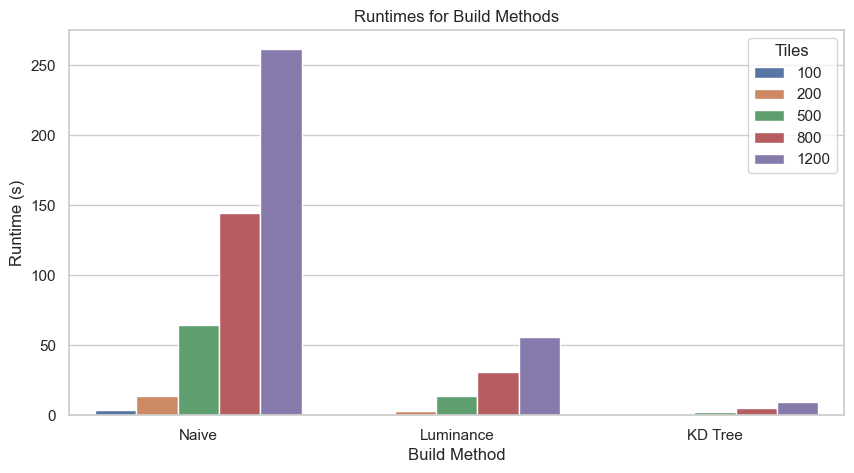

In [84]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Transpose runtimes
runtimes = np.array([tiles_100, tiles_200, tiles_500, tiles_800, tiles_1200]).T

# create example data
data = {'Tiles': ['100', '200', '500', '800', '1200']*3,
        'Runtimes': runtimes.flatten(),
        'Methods': ['Naive']*5 + ['Luminance']*5 + ['KD Tree']*5}

df = pd.DataFrame(data)
print(df)

# set up figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# use Seaborn to create bar chart
sns.barplot(x='Methods', y='Runtimes', hue='Tiles', data=df, ax=ax)

# set title and axis labels
ax.set_title('Runtimes for Build Methods')
ax.set_xlabel('Build Method')
ax.set_ylabel('Runtime (s)')

# show the chart
plt.show()
